<a href="https://colab.research.google.com/github/PKpacheco/project4_intro_ai/blob/main/(music)v1/Project_4_Intro_AI_Paola_Pacheco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project 4: Music Genre Classification (part 1)
Intro to AI
\
Instructor: Jeffrey Lanyon
\
Student: Paola Katherine Pacheco


**Objectives**: First, implement a machine learning model to classify music files into different
genres based on their audio features. Second, improve the spam classifier from the previous
project.

**Introduction:**
In this assignment, you will build a neural network model that can classify music files into
various genres using Mel-frequency cepstral coefficients (MFCCs) as features. You will use
Python libraries such as Librosa for audio processing, Keras, and TensorFlow for building and
training the neural network. Additionally, you will build a NN to improve the spam classifier
from the previous project.

**Requirements:**
1. Python Libraries: Ensure you have librosa, keras, and tensorflow installed in your
Python environment.
2. Datasets: You will use the GTZAN genre collection. Make sure you are familiar with the
dataset before you begin working on the coding portion. You will also need the YouTube
comments dataset from the last project.
3. Note: You may use the code snippets and functions provided in class or use your own
novel approach to accomplish the tasks outlined in the problems.


# Imports

In [1]:
# mount drive to use files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install librosa
# !pip install keras
# !pip install tensorflow

In [3]:
import os

import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler

from tabulate import tabulate


#1 Data Visualization:

* Write a function display_mfcc(song) that takes a music file as input, computes
its MFCCs, and displays the MFCCs. You may use the code provided in class for
this task or accomplish this task as you wish.
* Test this function with one song from each genre from the dataset.
* Display all of graphs for the songs you choose

In [4]:
# # get dataset
# gtzan = tfds.audio.gtzan.GTZAN()

In [5]:
url_genres= '/content/drive/MyDrive/Colab Notebooks/intro to ai/project_4/genres'

In [6]:
# get all subfolders
genres = [folder for folder in os.listdir(url_genres) if os.path.isdir(os.path.join(url_genres, folder))]

In [7]:
# print all genres
genres

['reggae',
 'hiphop',
 'classical',
 'jazz',
 'blues',
 'country',
 'metal',
 'rock',
 'disco',
 'pop']

In [8]:
def display_mfcc(song):
  y,sr = librosa.load(song)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)

  plt.figure(figsize=(10,4))
  librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
  plt.colorbar()
  plt.title(f'MFCC of{song}')
  plt.tight_layout()
  plt.show()

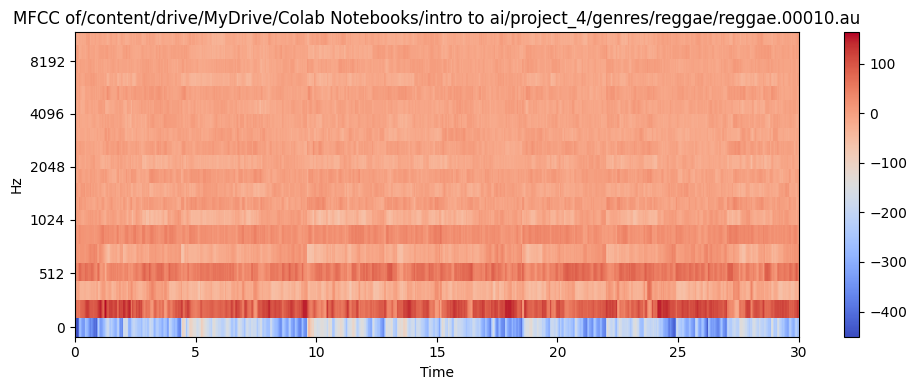

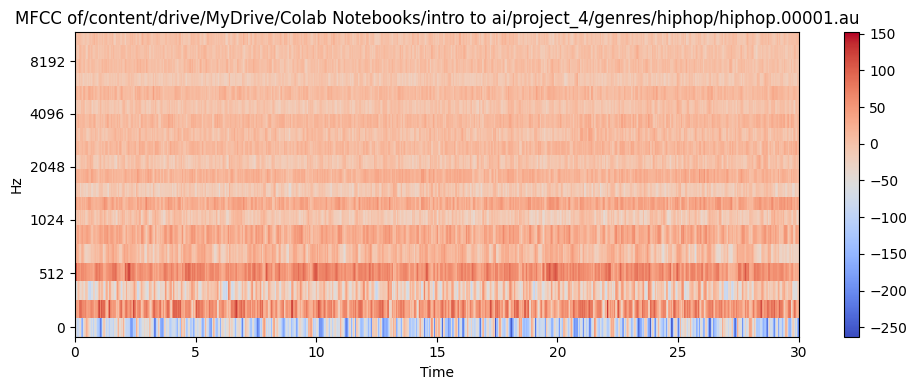

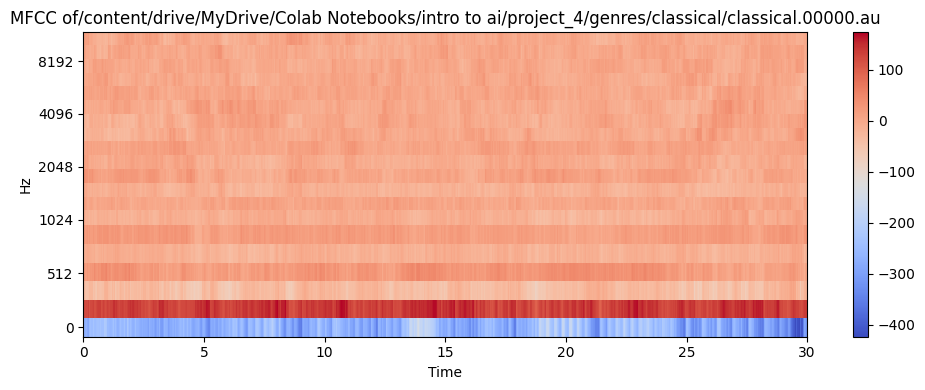

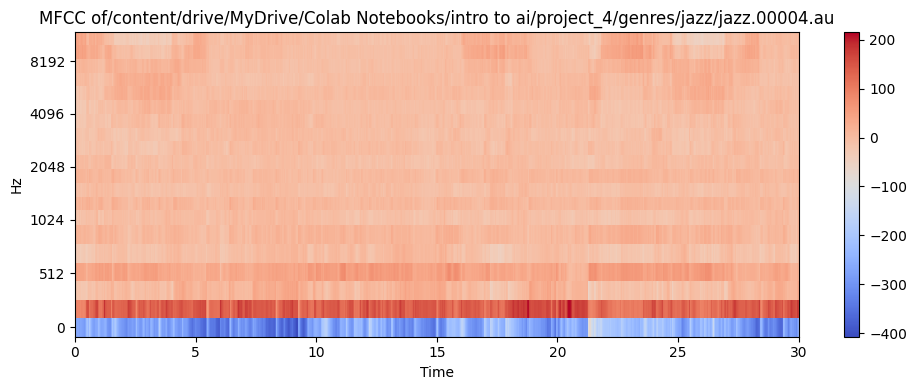

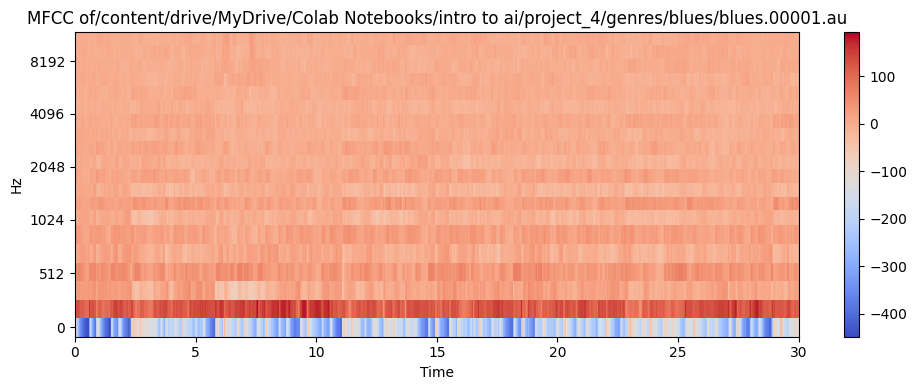

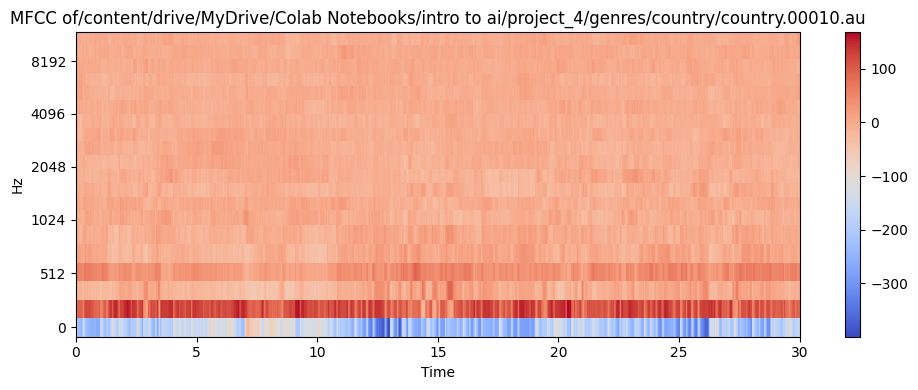

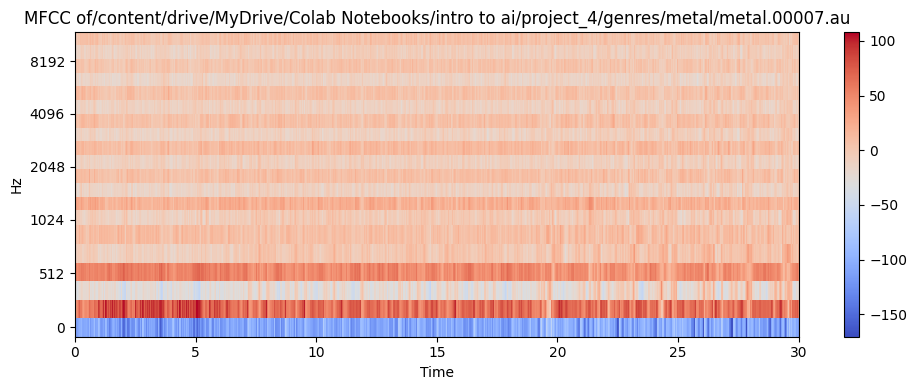

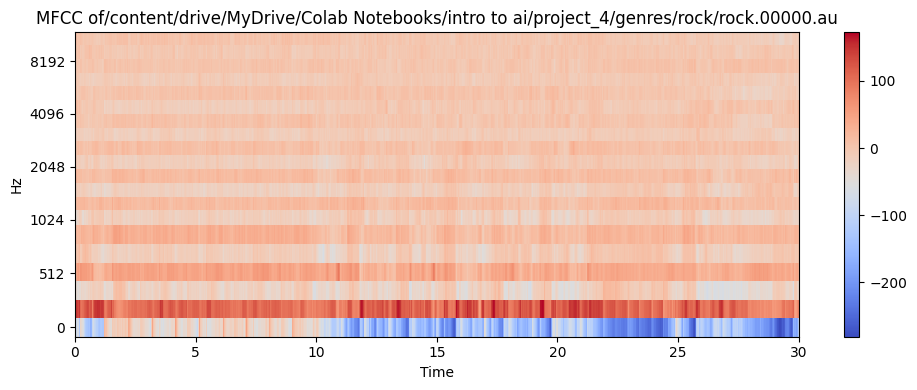

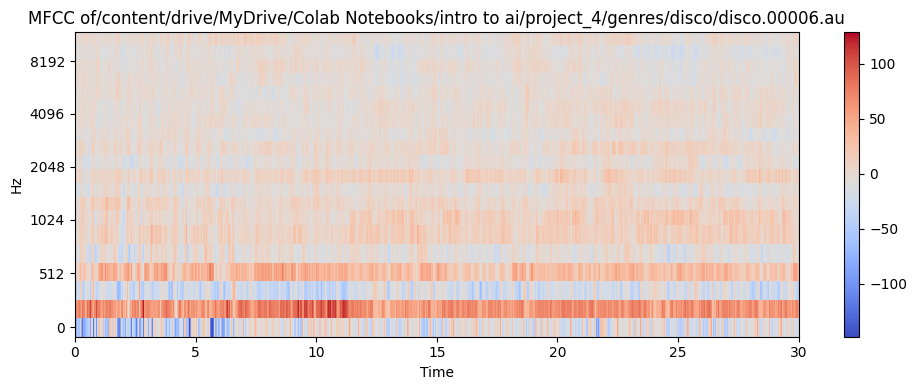

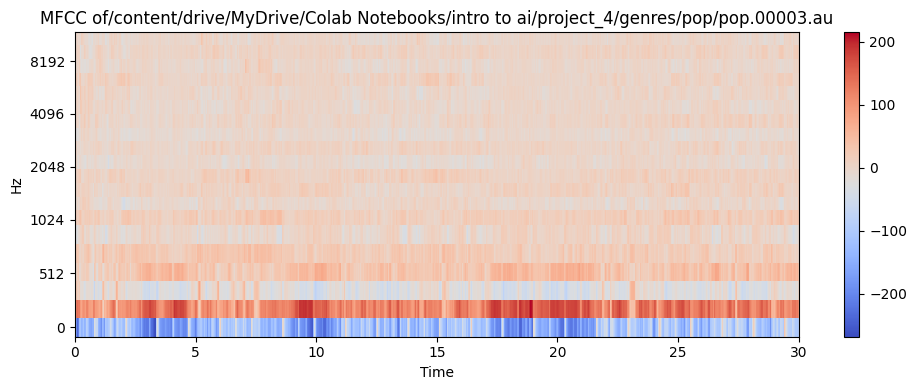

In [9]:
for genre in genres:
    # Get the list of audio files in the genre subfolder
    genre_folder = os.path.join(url_genres, genre)
    audio_files = [os.path.join(genre_folder, file) for file in os.listdir(genre_folder) if file.endswith('.au')]

    # get only 1 file inside each genre
    if audio_files:
        display_mfcc(audio_files[0])

#2 Feature Extraction:
* Implement the extract_features_song(f) function to extract MFCC features
from a given song file.
* Normalize these features as done in the provided code.


In [155]:
# copied and modified from 'https://www.kaggle.com/code/cookiefinder/genre-classification/notebook'
def extract_features_song(song):
    # return np.ndarray.flatten(mfcc)[:25000]
    y, sr = librosa.load(song)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:25000]

#3. Feature and Label Preparation:
* Modify the generate_features_and_labels() function to process all songs in
your dataset, extract features using the above function, and create genre labels for
each song.
* Convert these labels into a one-hot encoded format.


In [159]:
def generate_features_and_labels(audio_files, genres):
    all_features = []
    all_labels = []

    for label, genre in enumerate(genres):
        print('Processing %d songs in %s genre...' % (len(audio_files), genre))

        for audio_file in audio_files:
            features = extract_features_song(audio_file)
            all_features.append(features)
            all_labels.append(label)

    # label_encoder = LabelEncoder()
    # y_encoded = label_encoder.fit_transform(all_labels)
    # y_one_hot = to_categorical(y_encoded)
    # convert labels to one-hot encoding

    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    y_one_hot = to_categorical(label_row_ids, len(label_uniq_ids))

    return np.stack(all_features), y_one_hot

In [160]:
# run the function generate_features_and_labels and associate to data
features, labels = generate_features_and_labels(audio_files, genres)

Processing 100 songs in reggae genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in classical genre...
Processing 100 songs in jazz genre...
Processing 100 songs in blues genre...
Processing 100 songs in country genre...
Processing 100 songs in metal genre...
Processing 100 songs in rock genre...
Processing 100 songs in disco genre...
Processing 100 songs in pop genre...


In [129]:
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

Shape of features: (1000, 25000)
Shape of labels: (1000,)


In [151]:
labels = np.zeros(1000)
index = 0
for i in range(1000):
    if i % 100 == 0:
        index += 1
    labels[i] = index
labels -= 1

In [152]:
features = features.astype('float32')
labels = labels.astype('int64')

#4. Model Building:
* Construct a neural network using Keras with at least two layers: a dense layer with ReLU activation and an output layer with softmax activation.
* Compile the model with appropriate loss and optimizer functions.


In [132]:
# split data (80% training, 20% testing)
training_split = 0.8

In [133]:
# combine features ( not the last column label) and labels
alldata = np.column_stack((features[:, :-1], labels))

#shuffle data
np.random.shuffle(alldata)

In [134]:
alldata.shape

(1000, 25000)

In [135]:
# calculate index
split_idx = int(len(alldata) * training_split)
split_idx

800

In [136]:
# split data
train, test = alldata[:split_idx,:], alldata[split_idx:,:]


In [137]:
train.shape

(800, 25000)

In [138]:
test.shape

(200, 25000)

In [139]:
# separate features and labels training
train_input = train[:, :-10]
train_labels = train[:, -10:]

In [141]:
# separate features and labels test
test_input = test[:, :-10]
test_labels = test[:, -10:]


In [142]:
print ('Shape of train_input', train_input.shape)
print ('Shape of train_labels', train_labels.shape)
print ('Shape of test_input', test_input.shape)
print ('Shape of test_labels', test_labels.shape)


Shape of train_input (800, 24990)
Shape of train_labels (800, 10)
Shape of test_input (200, 24990)
Shape of test_labels (200, 10)


# Models

In [143]:
input_shape =np.shape(train_input)[1]
input_shape

24990

In [144]:
# neural networking model
model = Sequential()

# dense layer with ReLU activation
model.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))

# output layer with softmax activation
model.add(Dense(units=10, activation='softmax'))


In [145]:
# compiling the model withcategorical_crossentropy, for multi-class classification (10 genres)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [116]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 100)               2499100   
                                                                 
 dense_33 (Dense)            (None, 10)                1010      
                                                                 
Total params: 2500110 (9.54 MB)
Trainable params: 2500110 (9.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
# model 2
model_2 = Sequential()

# Dense layer with ReLU activation
model_2.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))

# dropout
model_2.add(Dropout(0.5))

model_2.add(Dense(units=64, activation='relu'))

# output
model_2.add(Dense(units=10, activation='softmax'))

# Compiling the model
model_2.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Displaying the model summary
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 100)               2499100   
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                6464      
                                                                 
 dense_27 (Dense)            (None, 10)                650       
                                                                 
Total params: 2506214 (9.56 MB)
Trainable params: 2506214 (9.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
model_3 = Sequential()

# input layer
model_3.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))
model_3.add(Dropout(0.5))

model_3.add(Dense(units=100, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(units=64, activation='relu'))
model_3.add(Dropout(0.5))

# output
model_3.add(Dense(units=10, activation='softmax'))

model_3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 100)               2499100   
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 100)               10100     
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                6464      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 10)               

#5. Training and Evaluation:
Split your data into training and testing sets and train your
model on the training data. Evaluate the performance of your model on the test data and
output the loss and accuracy. The following outlines how to appropriately prep the data,
you may use the detailed outline or prep your data as you wish

In [146]:
# define global variables
epochs = 10
batch_size = 32

In [147]:
# Train the first model
history_model_1 = model.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 1s 45ms/step - loss: -784.7525 - accuracy: 0.8891 - val_loss: -1434.8650 - val_accuracy: 0.9000
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: -3094.8542 - accuracy: 0.9234 - val_loss: -3844.6392 - val_accuracy: 0.9000
Epoch 3/10
20/20 [==============================] - 1s 37ms/step - loss: -6747.1572 - accuracy: 0.9234 - val_loss: -7521.7080 - val_accuracy: 0.9000
Epoch 4/10
20/20 [==============================] - 1s 35ms/step - loss: -12111.4199 - accuracy: 0.9234 - val_loss: -12761.8760 - val_accuracy: 0.9000
Epoch 5/10
20/20 [==============================] - 1s 36ms/step - loss: -19324.1152 - accuracy: 0.9234 - val_loss: -19627.2148 - val_accuracy: 0.9000
Epoch 6/10
20/20 [==============================] - 1s 35ms/step - loss: -29384.4941 - accuracy: 0.9234 - val_loss: -28239.3594 - val_accuracy: 0.9000
Epoch 7/10
20/20 [==============================] - 1s 36ms/step - loss: -40515.2734 - accuracy: 0.92

In [67]:
# Train the second model
history_model_2 = model_2.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 4s 125ms/step - loss: 4.1696 - accuracy: 0.7969 - val_loss: -23.4736 - val_accuracy: 0.9187
Epoch 2/10
20/20 [==============================] - 2s 88ms/step - loss: 17.1397 - accuracy: 0.9172 - val_loss: -275.1815 - val_accuracy: 0.9187
Epoch 3/10
20/20 [==============================] - 2s 90ms/step - loss: 315.3278 - accuracy: 0.9187 - val_loss: -1613.1106 - val_accuracy: 0.9187
Epoch 4/10
20/20 [==============================] - 2s 82ms/step - loss: 677.6553 - accuracy: 0.9187 - val_loss: -6240.1572 - val_accuracy: 0.9187
Epoch 5/10
20/20 [==============================] - 2s 79ms/step - loss: 4538.4990 - accuracy: 0.9187 - val_loss: -18470.3027 - val_accuracy: 0.9187
Epoch 6/10
20/20 [==============================] - 2s 86ms/step - loss: 7916.4204 - accuracy: 0.9187 - val_loss: -45387.5586 - val_accuracy: 0.9187
Epoch 7/10
20/20 [==============================] - 2s 105ms/step - loss: 15873.7793 - accuracy: 0.9187 - val_loss: -97

In [68]:
# Train the second model
history_model_3 = model_3.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/10
20/20 [==============================] - 4s 106ms/step - loss: 5.3782 - accuracy: 0.7125 - val_loss: -17.8824 - val_accuracy: 0.9187
Epoch 2/10
20/20 [==============================] - 2s 90ms/step - loss: 40.9814 - accuracy: 0.9156 - val_loss: -217.3051 - val_accuracy: 0.9187
Epoch 3/10
20/20 [==============================] - 2s 79ms/step - loss: 152.7387 - accuracy: 0.9187 - val_loss: -1329.6417 - val_accuracy: 0.9187
Epoch 4/10
20/20 [==============================] - 2s 89ms/step - loss: 811.3016 - accuracy: 0.9187 - val_loss: -5336.0962 - val_accuracy: 0.9187
Epoch 5/10
20/20 [==============================] - 2s 94ms/step - loss: 4271.7515 - accuracy: 0.9187 - val_loss: -16341.0732 - val_accuracy: 0.9187
Epoch 6/10
20/20 [==============================] - 2s 112ms/step - loss: 1588.3035 - accuracy: 0.9187 - val_loss: -39859.1484 - val_accuracy: 0.9187
Epoch 7/10
20/20 [==============================] - 2s 123ms/step - loss: 13718.2529 - accuracy: 0.9187 - val_loss: -8

In [69]:
test_loss_model_1, test_accuracy_model_1 = model.evaluate(test_input, test_labels, batch_size=batch_size)

7/7 [==============================] - 0s 8ms/step - loss: 63.6332 - accuracy: 0.8950


In [70]:
test_loss_model_2, test_accuracy_model_2 = model_2.evaluate(test_input, test_labels, batch_size=batch_size)


7/7 [==============================] - 0s 16ms/step - loss: 110076.9688 - accuracy: 0.8950


In [71]:
test_loss_model_3, test_accuracy_model_3 = model_3.evaluate(test_input, test_labels, batch_size=batch_size)


7/7 [==============================] - 0s 15ms/step - loss: 99781.1797 - accuracy: 0.8950


In [118]:
print(history_model_1.history['loss'])
print(history_model_1.history['val_loss'])

[1.828590750694275, 1.485443115234375, 0.8408197164535522, 2.833704710006714, 7.400249481201172, 7.732489109039307, 9.569595336914062, 15.566187858581543, 16.13762664794922, 12.410073280334473]
[-6.622089385986328, -15.970216751098633, -28.181360244750977, -44.765655517578125, -65.8566665649414, -90.82486724853516, -121.0778579711914, -155.97576904296875, -194.20843505859375, -236.9246063232422]


In [72]:
# function to create a table with results
def create_results_table(model_name, history, test_loss, test_accuracy):
    return [
        model_name,
        history.history['loss'][-1],
        history.history['val_loss'][-1],
        test_loss,
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        test_accuracy
    ]

In [73]:
# plot the table
def display_results_table(table_results):
    headers = ["Model", "Train Loss", "Validation Loss", "Test Loss", "Train Accuracy", "Validation Accuracy", "Test Accuracy"]
    print(tabulate([headers] + table_results, tablefmt="fancy_grid"))

In [74]:
# add values to the models results table
table_results_model_1 = create_results_table('Model 1', history_model_1, test_loss_model_1, test_accuracy_model_1)
table_results_model_2 = create_results_table('Model 2', history_model_2, test_loss_model_2, test_accuracy_model_2)
table_results_model_3 = create_results_table('Model 3', history_model_3, test_loss_model_3, test_accuracy_model_3)

In [85]:
# print results tables
display_results_table([table_results_model_1,
                       table_results_model_2,
                       table_results_model_3])

╒═════════╤═══════════════════╤════════════════════╤════════════════════╤═══════════════════╤═════════════════════╤════════════════════╕
│ Model   │ Train Loss        │ Validation Loss    │ Test Loss          │ Train Accuracy    │ Validation Accuracy │ Test Accuracy      │
├─────────┼───────────────────┼────────────────────┼────────────────────┼───────────────────┼─────────────────────┼────────────────────┤
│ Model 1 │ 69.25498962402344 │ -336.1478576660156 │ 63.633182525634766 │ 0.918749988079071 │ 0.918749988079071   │ 0.8949999809265137 │
├─────────┼───────────────────┼────────────────────┼────────────────────┼───────────────────┼─────────────────────┼────────────────────┤
│ Model 2 │ 144712.71875      │ -551837.5          │ 110076.96875       │ 0.918749988079071 │ 0.918749988079071   │ 0.8949999809265137 │
├─────────┼───────────────────┼────────────────────┼────────────────────┼───────────────────┼─────────────────────┼────────────────────┤
│ Model 3 │ 66164.2265625     │ -516304.5

In [76]:
label_t = 'Training Accuracy'
val_acc = 'Validation Accuracy'

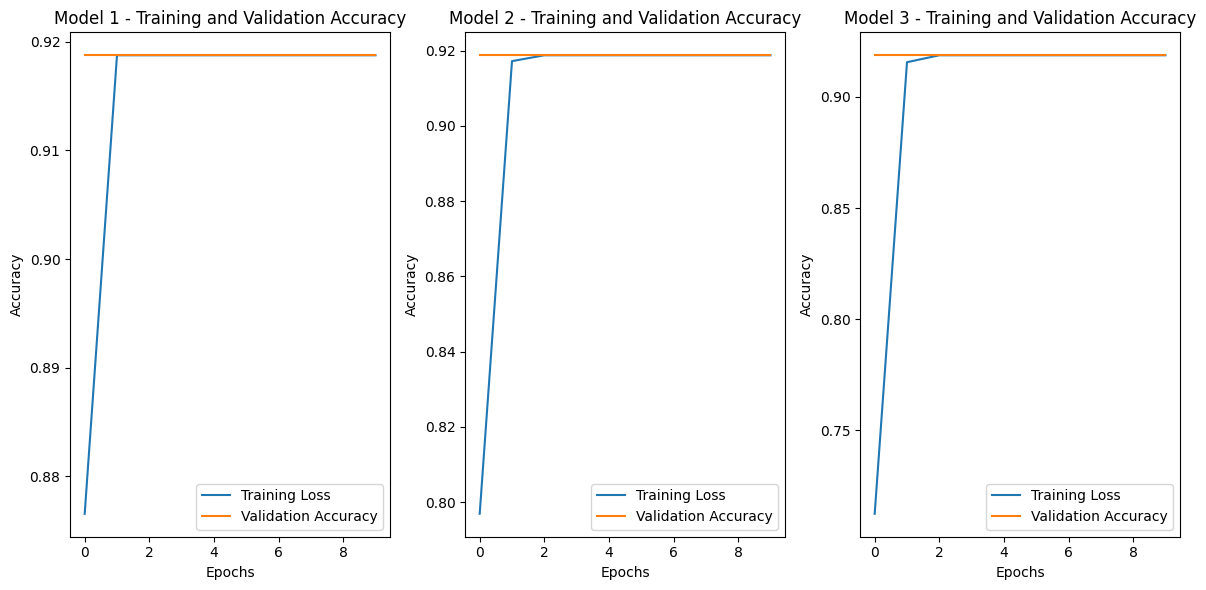

In [83]:

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 3, 1)
plt.plot(history_model_1.history['accuracy'], label=label_t)
plt.plot(history_model_1.history['val_accuracy'], label=val_acc)
plt.title('Model 1 - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Model 2
plt.subplot(1, 3, 2)
plt.plot(history_model_2.history['accuracy'], label=label_t)
plt.plot(history_model_2.history['val_accuracy'], label=val_acc)
plt.title('Model 2 - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Model 3
plt.subplot(1, 3, 3)
plt.plot(history_model_3.history['accuracy'], label=label_t)
plt.plot(history_model_3.history['val_accuracy'], label=val_acc)
plt.title('Model 3 - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


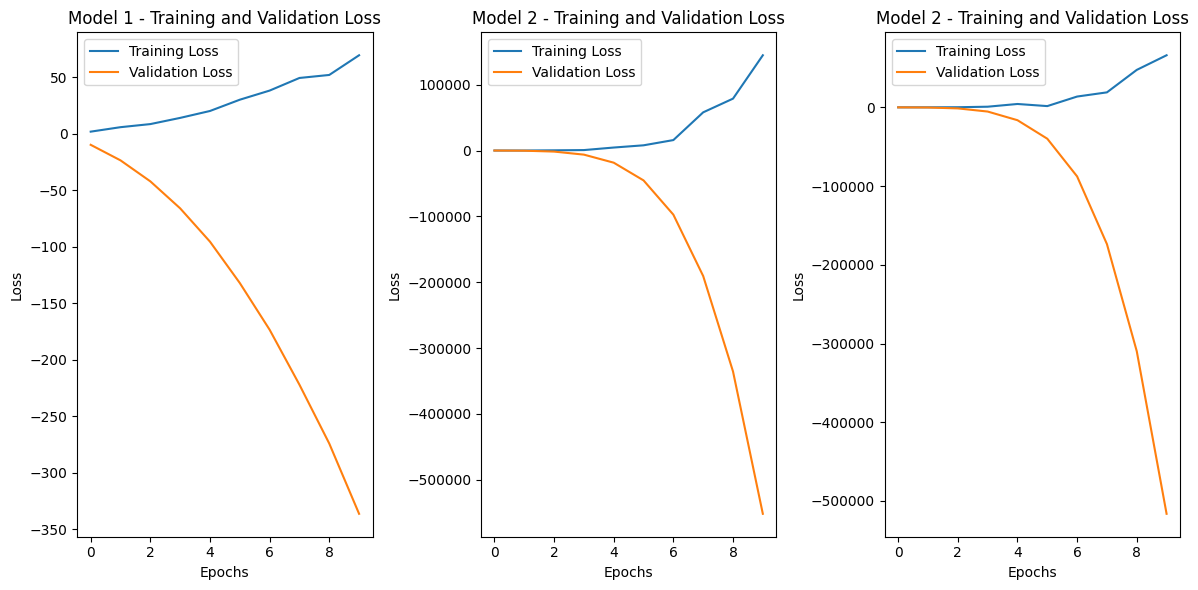

In [84]:
label_t = 'Training Loss'
label_val = 'Validation Loss'
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 3, 1)
plt.plot(history_model_1.history['loss'], label='Training Loss')
plt.plot(history_model_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2
plt.subplot(1, 3, 2)
plt.plot(history_model_2.history['loss'], label='Training Loss')
plt.plot(history_model_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()


# Model 3
plt.subplot(1, 3, 3)
plt.plot(history_model_3.history['loss'], label='Training Loss')
plt.plot(history_model_3.history['val_loss'], label='Validation Loss')
plt.title('Model 2 - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.show()